# Utilizing Machine Learning to Detect Flight Delays

### **Research Question**
How accurately (via recall) can flight delays be predicted using airline performance and weather data?

### **Project Outline**
1.	**Import and Clean Data:** Two datasets consisting of airline performance, and weather data.
2.	**PostgreSQL Database:** Create database from the cleaned datasets above, and then query database for finalized project dataset.
3.	**Exploratory Data Analysis.**
4.	**Machine Learning:** Scale data and train the two following models for binary classification (delayed flight or not delayed) to establish baseline performance. Both models will also undergo hyperparameter tuning and will have run-times and performance tracked.
 + Logistic Regression
 + Gradient Boosting Classifier
5.	**Principal Component Analysis:** Conduct PCA on data set to reduce dimensionality and ideally, increase model performance/efficiency.
6.	**Retrain Models:** Retrain both models after PCA using the optimally tuned hyperparameters.
7.	**Results, Observations, Conclusion:** Evaluate baseline, tuned, and post-PCA performance for both ML models.

### **Project Scope**

**Year:** 2019  
**Airline:** Delta  
**Origin Airports:**
* Atlanta (ATL)
* Detroit (DTW)
* LaGuardia (LGA) 
* Minneapolis/St. Pual (MSP)
* Salt Lake City (SLC)

### **Data Sources**
1.	**Airline On-Time Performance data:** Bureau of Transportation Statistics (BTS)
2.	**Hourly local climatological (weather) data:** National Oceanic and Atmospheric Administration (NOAA).

# Imports

In [1]:
# Imports & Database Connection

# Necessary imports for EDA & 'The Basics'
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math

# Necessary imports to connect to Postgresql
import sqlalchemy as db
import os
from dotenv import load_dotenv 

from sqlalchemy import create_engine

# Necessary imports for ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import metrics   

# Necessary imports for PCA
from sklearn.decomposition import PCA

# Load iPython-sql
%load_ext sql

# 1. DATAFRAMES: Create and Clean

## Airline Performance

In [2]:
# Enable display of all columns/rows for DataFrames

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Create DataFrame

# Load in all airline performance .csv files for 2019 and concat them into one large DataFrame
airline_months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
dataframes_list = []

for i in range(len(airline_months)):
    temp_df = pd.read_csv('AirlineData/' + airline_months[i] + '.csv')
    dataframes_list.append(temp_df)
    
airline_df = pd.concat(dataframes_list)

In [4]:
# Clean DataFrame

# DL = Delta Airlines

# ATL = Atlanta, Ga
# DTW = Detroit, MI
# LGA = LaGuardia, NY
# MSP = Minneapolis/St. Paul MN
# SLC = Salt Lake City, UT

airlines_keep = 'DL'
airports_keep = ['ATL', 'DTW', 'LGA', 'MSP', 'SLC']

# filter for Delta Airlines and top 5 origin airports.
airline_df = airline_df[airline_df['MKT_UNIQUE_CARRIER'] == airlines_keep]
airline_df = airline_df[airline_df['ORIGIN'].isin(airports_keep)]

# convert FL_DATE to datetime object
airline_df['FL_DATE'] =  pd.to_datetime(airline_df['FL_DATE'])

# extract scheduled departure hour and rename column
airline_df['CRS_DEP_TIME'] = airline_df['CRS_DEP_TIME']//100
airline_df = airline_df.rename(columns = {'CRS_DEP_TIME' : 'CRS_DEP_HR'})

In [5]:
airline_df.head()

,DAY_OF_WEEK,FL_DATE,MKT_UNIQUE_CARRIER,MKT_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_HR,DEP_TIME,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
3550,1,2019-01-14,DL,7360,14869,SLC,"Salt Lake City, UT",13127,LWS,"Lewiston, ID",11,1059.0,0.0,-1.0,1100-1159,1158,1153.0,0.0,-1.0,1100-1159,113.0,114.0,71.0,1,461,2,NaN,NaN,NaN,NaN,NaN
3552,1,2019-01-14,DL,7361,14869,SLC,"Salt Lake City, UT",14113,PIH,"Pocatello, ID",11,1159.0,1.0,3.0,1100-1159,1215,1242.0,1.0,1.0,1200-1259,65.0,43.0,28.0,1,150,1,27.0,0.0,0.0,0.0,0.0
3555,1,2019-01-14,DL,7363,13487,MSP,"Minneapolis, MN",10141,ABR,"Aberdeen, SD",11,1119.0,0.0,-1.0,1100-1159,1255,1255.0,0.0,0.0,1200-1259,91.0,96.0,43.0,1,257,2,NaN,NaN,NaN,NaN,NaN
3559,1,2019-01-14,DL,7367,11433,DTW,"Detroit, MI",10333,APN,"Alpena, MI",12,1202.0,0.0,-1.0,1200-1259,1335,1305.0,0.0,-2.0,1300-1359,81.0,63.0,43.0,1,198,1,NaN,NaN,NaN,NaN,NaN
3564,1,2019-01-14,DL,7371,13487,MSP,"Minneapolis, MN",10631,BJI,"Bemidji, MN",11,1127.0,0.0,-1.0,1100-1159,1254,1216.0,0.0,-2.0,1200-1259,84.0,49.0,35.0,1,199,1,NaN,NaN,NaN,NaN,NaN



## Weather

In [6]:
# create DataFrame

# specify columns to keep from raw input file
weather_keep = ['STATION', 'DATE', 'REPORT_TYPE', 'HourlyAltimeterSetting', 'HourlyDewPointTemperature', 
                'HourlyDryBulbTemperature', 'HourlyPrecipitation', 'HourlyRelativeHumidity', 
                'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility', 'HourlyWetBulbTemperature', 
                'HourlyWindDirection', 'HourlyWindGustSpeed', 'HourlyWindSpeed']

wdf = pd.read_csv('AirlineData/weather.csv', usecols = weather_keep, low_memory = False)

In [7]:
# clean DataFrame

# some columns contain mixed data types (floats and floats with alpha characters. ie - 1.5, and 1.5s)
# records with alpha characters in the columns listed below are outlier records and will be removed.
spec_char_list = ['HourlyAltimeterSetting', 'HourlyDewPointTemperature', 
                'HourlyDryBulbTemperature', 'HourlyPrecipitation', 
                'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility', 
                'HourlyWindDirection']

for i in spec_char_list:
    wdf = wdf[~wdf[i].str.contains(r'[sStTvV]', na = False)]

    
# filter for report type of 'FM-15'
wdf = wdf[wdf['REPORT_TYPE'] == 'FM-15']

# replace station ids with corresponding airport code.
wdf = wdf.replace({'STATION' : { 72503014732 : 'LGA', 72219013874 : 'ATL', 72537094847 : 'DTW', 
                                72572024127 : 'SLC', 72658014922 : 'MSP'}})


# separate date and time from 'DATE' column, format new date & time columns, extract hour from timestamp  
# 'DATE' column example: 2019-01-01T00:08:00

split_dt = wdf["DATE"].str.split("T", n = 1, expand = True)
  
# insert "CAL_DATE" and "HOUR" columns into wdf Data Frame
wdf["FLIGHT_DATE"]= split_dt[0]
wdf["HOUR"]= split_dt[1]
  
#  drop old "DATE" column
wdf.drop(columns =["DATE"], inplace = True)

# convert "CAL_DATE" and "HOUR" to datetime objects
# extract hour from scheduled flight time.

wdf['FLIGHT_DATE'] =  pd.to_datetime(wdf['FLIGHT_DATE'])
wdf['HOUR'] =  pd.to_datetime(wdf['HOUR'])
wdf['HOUR'] = wdf['HOUR'].dt.hour

In [8]:
wdf.head()

,STATION,REPORT_TYPE,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,FLIGHT_DATE,HOUR
1,LGA,FM-15,29.75,46,47,0.06,97.0,29.75,29.72,4,47.0,0,NaN,0.0,2019-01-01,0
5,LGA,FM-15,29.68,48,50,0.02,93.0,29.68,29.65,4,49.0,200,NaN,5.0,2019-01-01,1
9,LGA,FM-15,29.62,52,54,0,93.0,29.62,29.59,3,53.0,250,NaN,15.0,2019-01-01,3
12,LGA,FM-15,29.59,52,55,0,90.0,29.59,29.56,5,53.0,250,25.0,15.0,2019-01-01,4
15,LGA,FM-15,29.62,53,57,0,87.0,29.62,29.59,10,55.0,260,NaN,11.0,2019-01-01,5




# 2. DATABASE

## Export Cleaned DataFrames to .CSV Files for Database Creation

In [9]:
# Export DataFrames to .CSV files to be used in database creation
# Import DataFrames into a PostgreSQL database, with each DataFrame being its own table.

airline_df.to_csv(r'AirlineData/Cleaned_Airline_Performance_Data.csv', index = False)
wdf.to_csv(r'AirlineData\Cleaned_Weather_Data.csv', index = False)

## Connect to Database

In [10]:
# Connect to database w/ environmental variables
load_dotenv()
user = os.getenv('SQL_USER')
password = os.getenv('SQL_PASSWORD')
host = os.getenv('SQL_HOST')
db = os.getenv('SQL_DB')

conn_text = 'postgresql://{}:{}@{}/{}'.format(user,password,host,db)

%sql $conn_text
engine = create_engine(conn_text)

## Query Database to Obtain Finalized Dataset

In [11]:
# Query database for matching flight and weather records. Store results in a new DataFrame.
# Project scope was limited to ~100,000 records, as indicated by the limit quantity.

q = '''
SELECT setseed(0.5);
SELECT * FROM flights
INNER JOIN weather 
ON flights.origin = weather.airport
    AND flights.fl_date = weather.flight_date 
    AND flights.crs_dep_hr = weather.hour     
ORDER BY RANDOM()  
LIMIT 105000
'''

df = pd.read_sql (q, engine)

In [12]:
df.head()

,day_of_week,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_del15,dep_delay_group,dep_time_blk,crs_arr_time,arr_time,arr_del15,arr_delay_group,arr_time_blk,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,crs_dep_hr,airport,station,flight_date,time,hour,report_type,hourlyaltimetersetting,hourlydewpointtemperature,hourlydrybulbtemperature,hourlyprecipitation,hourlyrelativehumidity,hourlysealevelpressure,hourlystationpressure,hourlyvisibility,hourlywetbulbtemperature,hourlywinddirection,hourlywindgustspeed,hourlywindspeed
0,7,2019-05-05,DL,3471,10397,ATL,"Atlanta, GA",15249,TLH,"Tallahassee, FL",1213,1207.0,0.0,-1.0,1200-1259,1317,1302.0,0.0,-1.0,1300-1359,64,55.0,40.0,1,223,1,NaN,NaN,NaN,NaN,NaN,12,ATL,72219013874,2019-05-05,12:52:00,12,FM-15,29.82,63.0,77.0,0.0,62.0,29.80,28.73,10.0,68.0,280.0,18.0,13.0
1,5,2019-08-09,DL,1200,10397,ATL,"Atlanta, GA",10721,BOS,"Boston, MA",1130,1133.0,0.0,0.0,1100-1159,1406,1358.0,0.0,-1.0,1400-1459,156,145.0,122.0,1,946,4,NaN,NaN,NaN,NaN,NaN,11,ATL,72219013874,2019-08-09,11:52:00,11,FM-15,30.00,67.0,90.0,0.0,47.0,29.96,28.90,10.0,74.0,310.0,20.0,13.0
2,4,2019-07-11,DL,644,10397,ATL,"Atlanta, GA",10994,CHS,"Charleston, SC",810,807.0,0.0,-1.0,0800-0859,922,906.0,0.0,-2.0,0900-0959,72,59.0,42.0,1,259,2,NaN,NaN,NaN,NaN,NaN,8,ATL,72219013874,2019-07-11,8:52:00,8,FM-15,30.01,73.0,80.0,0.0,79.0,29.97,28.91,10.0,75.0,200.0,NaN,6.0
3,2,2019-06-11,DL,1626,14869,SLC,"Salt Lake City, UT",13198,MCI,"Kansas City, MO",944,937.0,0.0,-1.0,0900-0959,1308,1253.0,0.0,-1.0,1300-1359,144,136.0,114.0,1,920,4,NaN,NaN,NaN,NaN,NaN,9,SLC,72572024127,2019-06-11,9:54:00,9,FM-15,30.29,38.0,75.0,0.0,26.0,30.15,25.95,10.0,55.0,310.0,NaN,5.0
4,6,2019-04-06,DL,1481,10397,ATL,"Atlanta, GA",13577,MYR,"Myrtle Beach, SC",1558,1556.0,0.0,-1.0,1500-1559,1706,1654.0,0.0,-1.0,1700-1759,68,58.0,44.0,1,317,2,NaN,NaN,NaN,NaN,NaN,15,ATL,72219013874,2019-04-06,15:52:00,15,FM-15,30.11,60.0,71.0,0.0,68.0,30.10,29.01,9.0,64.0,130.0,NaN,7.0


## Address NULL's and 0's

In [13]:
# Print out list of columns with NULL and "0" values

null_values = df.isna()
null_columns = null_values.any()
cols_with_null = df.columns[null_columns].tolist()

df_missing = pd.DataFrame({'NULL': df[cols_with_null].isnull().sum(),
                    'zeros': (df[cols_with_null] == 0).sum()})
df_missing

,NULL,zeros
dep_time,521,0
dep_del15,521,87943
dep_delay_group,521,23039
arr_time,579,0
arr_del15,838,87656
arr_delay_group,838,16096
actual_elapsed_time,838,0
air_time,838,0
carrier_delay,88494,7867
weather_delay,88494,15328


In [14]:
# Records with NULL values will be removed. Exception: records with NULL values in the columns listed in keep_null_cols. 
# NULL values in these columns mean "no dealys" or "no wind gusts", respectively.
keep_null_cols= ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay', 'hourlywindgustspeed']

# Remove keep_null_cols from the list of columns containing NULL values
for i in keep_null_cols:
    cols_with_null.remove(i)
    
# Remove records with columns containing NULL
for i in cols_with_null:
    df = df[df[i].notnull()] 
    
# replace all remaining NULL values with zero's
df = df.fillna(0)

# 3. EXPLORATORY DATA ANALYSIS

In [15]:
# create 2 dataframes. 
# df will be used for EDA
# dfml will be used for the machine learning portion


dfml = df.drop(columns = ['mkt_unique_carrier', 'airport', 'station', 'flight_date', 'time', 'report_type',
                        'day_of_week', 'origin', 'origin_city_name', 'dest', 'dest_city_name', 'dep_time', 
                        'dep_del15', 'dep_delay_group', 'dep_time_blk', 'arr_time', 'arr_delay_group', 'arr_time_blk', 
                        'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights', 'distance', 'distance_group', 
                        'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay', 'crs_dep_hr', 
                        'hour', 'fl_date'])

df = df.drop(columns = ['mkt_carrier_fl_num', 'mkt_unique_carrier', 'origin_airport_id', 'dest_airport_id', 
                        'airport', 'station', 'flight_date', 'time', 'hour', 'report_type'])

## EDA Plots

<ipython-input-16-0517dce9b986>:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_yticklabels(['Unknown', '< -15' ,'-15 - -1', '0 - 14', '15 - 29', '30 - 44', '45 - 59', '60 - 74', '75 - 89'],


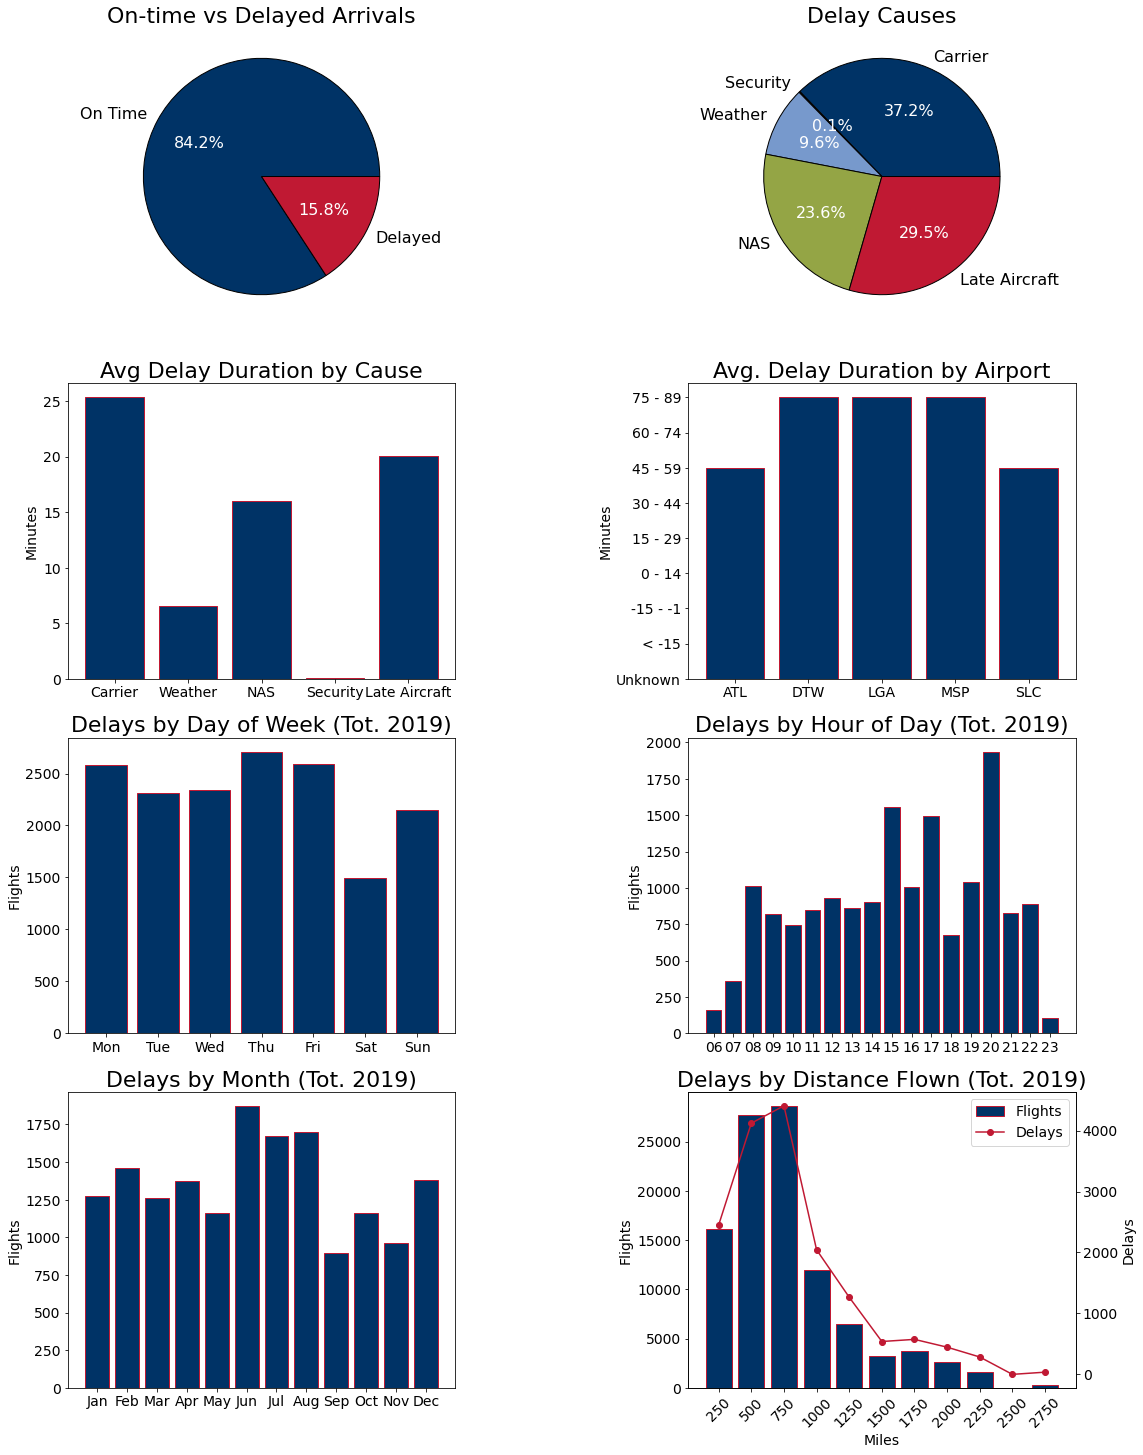

In [16]:
# 8 plots (AX1 - AX8), read from left to right, top to bottom.

# global plot settings
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(20,25))
fig.subplots_adjust(left=0.2, wspace=0.6)
fontsize = 14




#### AX1 - On-time vs Delayed Arrivals Pie Chart ########################################

# data for pie chart
total_num_flights = df['flights'].sum() 
total_num_delayed_flights = df['arr_del15'].sum()
on_time = total_num_flights - total_num_delayed_flights

# plot pie chart
slices_plt_1 = [on_time, total_num_delayed_flights]
labels_plt_1 = ['On Time', 'Delayed']
colors_plt_1 = ['#003366', '#C01933']
patches, texts, pcts = ax1.pie(slices_plt_1, labels = labels_plt_1, colors = colors_plt_1, wedgeprops={'edgecolor': 'black'}, 
                               textprops={'size': 16}, autopct='%1.1f%%')
plt.setp(pcts, color='white')
ax1.set_title('On-time vs Delayed Arrivals', {'fontsize': 22})




#### AX2 - Delay Causes Pie Chart #######################################################

# sum up all delay durations, per delay category
cols_to_sum = ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']
summed_mins_delayed = df[cols_to_sum].sum()


# function to calculate prorated portions of delays =
# delay catgeory total minutes / all delays total minutes * total number of delayed flights 
def func(str):
    result = summed_mins_delayed[str]/summed_mins_delayed.sum()*total_num_delayed_flights.astype(int)
    return result

# assign results to repspective variables
carrier_delay_prorated = func('carrier_delay')
security_delay_prorated = func('security_delay')
weather_delay_prorated = func('weather_delay')
nas_delay_prorated = func('nas_delay')
late_aircraft_delay_prorated = func('late_aircraft_delay')

# plot pie chart
slices_plt_2 = [carrier_delay_prorated, security_delay_prorated, weather_delay_prorated, 
                nas_delay_prorated, late_aircraft_delay_prorated]
labels_plt_2 = ['Carrier', 'Security', 'Weather', 'NAS', 'Late Aircraft']
colors_plt_2 = ['#003366', '#EA8A1A', '#7799CC', '#94A545', '#C01933']
patches, texts, pcts = (ax2.pie(slices_plt_2, labels = labels_plt_2, colors = colors_plt_2, wedgeprops={'edgecolor': 'black'}, 
                               textprops={'size': 16}, autopct='%1.1f%%'))
plt.setp(pcts, color='white')
ax2.set_title('Delay Causes', {'fontsize': 22})




#### AX3 - Avg. Delay Duration by Cause Bar Chart ######################################

# calculate the average delay duration per category
df_delays_only = df[df['arr_del15'] == 1]
cols_to_mean = ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']
df_delayAvgs = df_delays_only[cols_to_mean].mean()

# plot bar chart
x_labels_plt_3 = ['Carrier', 'Weather', 'NAS', 'Security', 'Late Aircraft']
ax3.bar(x_labels_plt_3, height = df_delayAvgs, color = '#003366', edgecolor='#C01933')
ax3.set_title('Avg Delay Duration by Cause', {'fontsize': 22})
ax3.tick_params(axis='x', labelsize=fontsize)
ax3.tick_params(axis='y', labelsize=fontsize)
ax3.set_ylabel('Minutes', color="black", fontsize=fontsize)




#### AX4 -  Avg. Delay Duration by Airport Bar Chart ####################################

# calculate the average delay duration by airport
x_labels_plt_4 = ['ATL', 'DTW', 'LGA', 'MSP', 'SLC']
df_delays_only = df[df['arr_del15'] == 1]
df_delay_orig = df_delays_only.groupby(['origin'])['arr_delay_group'].mean().round(0).astype(int)

# plot bar chart
ax4.bar(x_labels_plt_4, height = df_delay_orig, color=('#003366'),  edgecolor='#C01933')
ax4.set_title('Avg. Delay Duration by Airport', {'fontsize': 22})
ax4.set_yticklabels(['Unknown', '< -15' ,'-15 - -1', '0 - 14', '15 - 29', '30 - 44', '45 - 59', '60 - 74', '75 - 89'], 
                    fontsize = 14)
ax4.set_ylabel('Minutes', color="black", fontsize=fontsize)
ax4.tick_params(axis='x', labelsize=fontsize)




#### AX5 - Delays by Day of Week Bar Chart #############################################

# gather number of delays by day of week
df_delay_by_day = df.groupby(['day_of_week'])[['arr_del15']].sum()

# plot bar chart
x_labels_plt_5 = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
y_labels_plt_5 = df_delay_by_day['arr_del15']
ax5.bar(x_labels_plt_5, y_labels_plt_5, color=('#003366'),  edgecolor='#C01933')
ax5.set_title('Delays by Day of Week (Tot. 2019)', {'fontsize': 22})
ax5.set_ylabel('Flights', color="black", fontsize=fontsize)
ax5.tick_params(axis='x', labelsize=fontsize)
ax5.tick_params(axis='y', labelsize=fontsize)




#### AX6 - Delays by Hour Bar Chart ###################################################

# gather number delays by crs_dep_hr (Computer Reservation System departure hour: hour when plane was scheduled to depart)
df_delay_by_hour = df.groupby(['crs_dep_hr'])[['arr_del15']].sum()

# resort the index to ascending hours; only plot hours with more than 30 delays to remove extreme outliers
df_delay_by_hour = df_delay_by_hour.sort_values(by = ['crs_dep_hr'], ascending = True)
df_delay_by_hour = df_delay_by_hour[df_delay_by_hour['arr_del15'] > 30]

# plot bar chart
x_labels_plt_6 = ['06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
y_labels_plt_6 = df_delay_by_hour['arr_del15']
ax6.set_title('Delays by Hour of Day (Tot. 2019)', {'fontsize': 22})
ax6.bar(x_labels_plt_6, y_labels_plt_6, color='#003366',  edgecolor='#C01933')
ax6.set_ylabel('Flights', color="black", fontsize=fontsize)
ax6.tick_params(axis='x', labelsize=fontsize)
ax6.tick_params(axis='y', labelsize=fontsize)




##### AX7 Delays by Month Bar Chart ##################################################

# gather number of flight delays by month
df['fl_date'] =  pd.to_datetime(df['fl_date'])
df['flight_month'] = df['fl_date'].dt.month
df_delay_by_month = df.groupby(['flight_month'])[['arr_del15']].sum()

# plot bar chart
x_labels_plt_7 = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
y_labels_plt_7 =  df_delay_by_month['arr_del15']
ax7.set_title('Delays by Month (Tot. 2019)', {'fontsize': 22})
ax7.bar(x_labels_plt_7, y_labels_plt_7, color=('#003366'),  edgecolor='#C01933')
ax7.set_ylabel('Flights', color="black", fontsize=fontsize)
ax7.tick_params(axis='x', labelsize=fontsize)
ax7.tick_params(axis='y', labelsize=fontsize)




#### AX8 - Delays by Distance Flown ##################################################

# gather number of flights, and delays by distance grouping
df_flights_by_distance = df.groupby(['distance_group'])[['flights']].sum()
df_delay_by_distance = df.groupby(['distance_group'])[['arr_del15', 'flights']].sum()

# plot 1st axis: number of flights per distance grouping
x_labels_plt_8 = ['250', '500', '750', '1000', '1250', '1500', '1750', '2000', '2250', '2500', '2750']
ax8.bar(x_labels_plt_8, df_flights_by_distance['flights'], color="#003366", edgecolor='#C01933', label = 'Flights')
ax8.set_xlabel("Miles", fontsize=fontsize)
ax8.set_ylabel("Flights",fontsize=fontsize)
ax8.tick_params(axis='y', labelsize=fontsize)
ax8.tick_params(axis='x', labelsize=fontsize, rotation = 45)

# plot 2nd axis: number of delays per distance grouping
ax8_second_axis = ax8.twinx()
ax8_second_axis.plot(x_labels_plt_8, df_delay_by_distance['arr_del15'], color='#C01933', marker = "o", label = 'Delays')
ax8_second_axis.set_title('Delays by Distance Flown (Tot. 2019)', {'fontsize': 22})
ax8_second_axis.set_ylabel('Delays', color="black", fontsize=fontsize)
ax8_second_axis.tick_params(axis='y', labelsize=fontsize)

# Legend
handles, labels = ax8.get_legend_handles_labels()
handles2, labels2 = ax8_second_axis.get_legend_handles_labels()
handles_combined = handles + handles2
labels_combined = labels +  labels2
ax8.legend(handles_combined, labels_combined, prop={'size': 14})

plt.show()

# 4. MACHINE LEARNING

## Train/Test/Split

In [17]:
# assign arr_del15 as label for machine learning models.
# train/test/split
X = dfml.drop(columns = ['arr_del15'])
y = dfml.arr_del15

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

## Scale Data

In [18]:
# scale Data and save to train/test DataFrames
scaler = StandardScaler()

scaled_data = scaler.fit_transform(X_train)
train_df_scaled = pd.DataFrame(scaled_data)

scaled_testData = scaler.transform(X_test)
test_df_scaled = pd.DataFrame(scaled_testData)

X_train = train_df_scaled
X_test = test_df_scaled

# Logistic Regression Classifier

## Logistic Regression Classifier: Baseline

In [19]:
%%time

# establish baseline performance 
lr = LogisticRegression()
lr.fit(X_train, y_train)

Wall time: 123 ms


LogisticRegression()

In [20]:
# make predictions
lr_pred = lr.predict(X_test)

# Measure accuracy, precision, and recall
lr_acc = accuracy_score(y_test, lr_pred)
lr_prec = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)

print("Accuracy: ", lr_acc)
print("Precision: ",  lr_prec)
print("Recall: ", lr_recall)

Accuracy:  0.8428976439534657
Precision:  0.45714285714285713
Recall:  0.019987507807620236


## Logistic Regression Classifier: Hyperparameter Tuning

In [21]:
#Logistic Regression - round 1

# Parameters
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# space['penalty'] = ['l2'] ### leaving penalty out during first round of tuning until  best Solver is known.
space['C'] = [100, 10, 1.0, 0.1, 0.01]
space['random_state'] = [42]

# train model
lr = LogisticRegression()
rand_search_lr = RandomizedSearchCV(lr, space, n_iter = 25, scoring = 'accuracy', n_jobs = -1)
rand_search_lr.fit(X_train, y_train)

# show best parameters
rand_search_lr.best_params_

{'solver': 'newton-cg', 'random_state': 42, 'C': 0.01}

In [22]:
#Logistic Regression - round 2

space = dict()
space['solver'] = ['newton-cg']
space['penalty'] = ['l2']
space['C'] = [0.001, 0.005, 0.01, 0.05, 0.1]
space['random_state'] = [42]

lr = LogisticRegression()
rand_search_lr_2 = RandomizedSearchCV(lr, space, n_iter = 5, scoring = 'accuracy', n_jobs = -1)
rand_search_lr_2.fit(X_train, y_train)

rand_search_lr_2.best_params_

{'solver': 'newton-cg', 'random_state': 42, 'penalty': 'l2', 'C': 0.01}

In [23]:
#Logistic Regression - round 3

space = dict()
space['solver'] = ['newton-cg']
space['penalty'] = ['l2']
space['C'] = [0.005, 0.008, 0.01, 0.03, 0.05]
space['random_state'] = [42]

lr = LogisticRegression()
rand_search_lr_3 = RandomizedSearchCV(lr, space, n_iter = 5, scoring = 'accuracy', n_jobs = -1)
rand_search_lr_3.fit(X_train, y_train)

rand_search_lr_3.best_params_

{'solver': 'newton-cg', 'random_state': 42, 'penalty': 'l2', 'C': 0.01}

In [24]:
#Logistic Regression - round 4

space = dict()
space['solver'] = ['lbfgs']
space['penalty'] = ['l2']
space['C'] = [.008, .009, .01, .0125, .015, .0175, .02]
space['random_state'] = [42]

lr = LogisticRegression()
rand_search_lr_4 = RandomizedSearchCV(lr, space, n_iter = 7, scoring = 'accuracy', n_jobs = -1)
rand_search_lr_4.fit(X_train, y_train)

rand_search_lr_4.best_params_

{'solver': 'lbfgs', 'random_state': 42, 'penalty': 'l2', 'C': 0.015}

## Logistic Regression Classifier: Optimal Hyperparameters Found & Model Retrained

In [25]:
%%time 

# train model with optimal hyperparameters
lr_opt = LogisticRegression(**rand_search_lr_4.best_params_)
lr_opt.fit(X_train, y_train)

Wall time: 108 ms


LogisticRegression(C=0.015, random_state=42)

In [26]:
# make predictions
lr_pred = rand_search_lr_4.predict(X_test)

# Measure accuracy, precision, and recall
lr_acc_opt = accuracy_score(y_test, lr_pred)
lr_prec_opt = precision_score(y_test, lr_pred)
lr_recall_opt = recall_score(y_test, lr_pred)

print("Accuracy: ", lr_acc_opt)
print("Precision: ",  lr_prec_opt)
print("Recall: ", lr_recall_opt)

Accuracy:  0.8430931664874377
Precision:  0.47058823529411764
Recall:  0.019987507807620236


# Gradient  Boosting Classifier

## Gradient  Boosting Classifier: Baseline

In [27]:
%%time 

# establish baseline performance
gbc_baseline = GradientBoostingClassifier()
gbc_baseline.fit(X_train, y_train)

Wall time: 11.2 s


GradientBoostingClassifier()

In [28]:
# make predictions
gbc_pred = gbc_baseline.predict(X_test)

# Measure accuracy, precision, and recall
gbc_acc = accuracy_score(y_test, gbc_pred)
gbc_prec = precision_score(y_test, gbc_pred)
gbc_recall = recall_score(y_test, gbc_pred)

print("Accuracy: ", gbc_acc)
print("Precision: ",  gbc_prec)
print("Recall: ", gbc_recall)

Accuracy:  0.8515006354482354
Precision:  0.6961722488038278
Recall:  0.09088069956277327


## Gradient  Boosting Classifier: Hyperparameter Tuning

In [29]:
#Gradient Boosting Classifier - round 1

# parameters
space = dict()
space['learning_rate'] = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5, 1.75, 2.0]
space['n_estimators'] = [1, 5, 10, 25, 50, 75, 100, 125, 150, 175, 200, 250, 300, 400, 500]
space['max_depth'] = [3, 7, 9, 11, 13, 17, 20]
space['random_state'] = [42]
    
# train model
gbc = GradientBoostingClassifier()
rand_search_gbc = RandomizedSearchCV(gbc, space, n_iter=10, scoring = 'accuracy')
rand_search_gbc.fit(X_train, y_train)

# show best parameters
rand_search_gbc.best_params_

{'random_state': 42,
 'n_estimators': 500,
 'max_depth': 11,
 'learning_rate': 0.09}

In [31]:
#Gradient Boosting Classifier - round 2

space = dict()
space['learning_rate'] = np.arange(0.01, 0.1, .02)
space['n_estimators'] = np.arange(100, 700, 25)
space['max_depth'] = np.arange(9, 17)
space['random_state'] = [42]

gbc = GradientBoostingClassifier()
rand_search_gbc_2 = RandomizedSearchCV(gbc, space, n_iter=10, scoring = 'accuracy')
rand_search_gbc_2.fit(X_train, y_train)

rand_search_gbc_2.best_params_

{'random_state': 42,
 'n_estimators': 600,
 'max_depth': 12,
 'learning_rate': 0.03}

In [32]:
#Gradient Boosting Classifier - round 3

space = dict()
space['learning_rate'] = np.arange(.03, .09, .01)
space['n_estimators'] = np.arange(500, 600, 10)
space['max_depth'] = np.arange(10, 14)
space['random_state'] = [42]
    
gbc = GradientBoostingClassifier()
rand_search_gbc_3 = RandomizedSearchCV(gbc, space, n_iter=7, scoring = 'accuracy')
rand_search_gbc_3.fit(X_train, y_train)

rand_search_gbc_3.best_params_

{'random_state': 42,
 'n_estimators': 590,
 'max_depth': 12,
 'learning_rate': 0.05}

In [33]:
#Gradient Boosting Classifier - round 4

space = dict()
space['learning_rate'] = np.arange(.03, .07, .01)
space['n_estimators'] = np.arange(585, 605, 3)
space['max_depth'] = np.arange(12)
space['random_state'] = [42]
    
gbc = GradientBoostingClassifier()
rand_search_gbc_4 = RandomizedSearchCV(gbc, space, n_iter=1, scoring = 'accuracy')
rand_search_gbc_4.fit(X_train, y_train)

rand_search_gbc_4.best_params_

{'random_state': 42,
 'n_estimators': 603,
 'max_depth': 7,
 'learning_rate': 0.04}

## Gradient  Boosting Classifier: Optimal Hyperparameters Found & Model Retrained

In [34]:
%%time 

# train model with optimal hyperparameters
gbc_opt = GradientBoostingClassifier(**rand_search_gbc_4.best_params_)
gbc_opt.fit(X_train, y_train)

Wall time: 2min 34s


GradientBoostingClassifier(learning_rate=0.04, max_depth=7, n_estimators=603,
                           random_state=42)

In [35]:
# make predictions
gbc_pred = rand_search_gbc_4.predict(X_test)

# Measure accuracy, precision, and recall
gbc_acc_opt = accuracy_score(y_test, gbc_pred)
gbc_prec_opt = precision_score(y_test, gbc_pred)
gbc_recall_opt = recall_score(y_test, gbc_pred)

print("Accuracy: ", gbc_acc_opt)
print("Precision: ",  gbc_prec_opt)
print("Recall: ", gbc_recall_opt)

Accuracy:  0.8603969107439633
Precision:  0.7064439140811456
Recall:  0.1848844472204872


# 5. PRINCIPAL COMPONENT ANALYSIS

In [36]:
# Perform Principal Component Analysis
# Configure to keep 95% of the variance. Execute fit_transform to reduce components.
pca = PCA(n_components=0.95)
X_reduced_train = pca.fit_transform(X_train)
X_reduced_test = pca.transform(X_test)
pca.n_components_

12

# 6. RETRAIN MODELS

## PCA: Logistic Regression

In [37]:
%%time 

# train optimal Logistic Regression model after PCA
lr_opt = LogisticRegression(**rand_search_lr_4.best_params_)
lr_opt.fit(X_reduced_train, y_train)

Wall time: 64.8 ms


LogisticRegression(C=0.015, random_state=42)

In [38]:
# make predictions
lr_opt_pred = lr_opt.predict(X_reduced_test)

# Measure accuracy, precision, and recall
lr_acc_PCA = accuracy_score(y_test, lr_opt_pred)
lr_prec_PCA = precision_score(y_test, lr_opt_pred)
lr_recall_PCA = recall_score(y_test, lr_opt_pred)

print("Accuracy: ", lr_acc_PCA)
print("Precision: ",  lr_prec_PCA)
print("Recall: ", lr_recall_PCA)

Accuracy:  0.8431909277544237
Precision:  0.47619047619047616
Recall:  0.018738288569643973


## PCA : Gradient Boosting

In [39]:
%%time 

# train optimal Gradient Boosting model after PCA
gbc_opt = GradientBoostingClassifier(**rand_search_gbc_4.best_params_)
gbc_opt.fit(X_reduced_train, y_train)

Wall time: 5min 40s


GradientBoostingClassifier(learning_rate=0.04, max_depth=7, n_estimators=603,
                           random_state=42)

In [40]:
# make predictions
gbc_opt_pred = gbc_opt.predict(X_reduced_test)

# measure accuracy, precision, and recall
gbc_acc_PCA = accuracy_score(y_test, gbc_opt_pred)
gbc_prec_PCA = precision_score(y_test, gbc_opt_pred)
gbc_recall_PCA = recall_score(y_test, gbc_opt_pred)

print("Accuracy: ", gbc_acc_PCA)
print("Precision: ",  gbc_prec_PCA)
print("Recall: ", gbc_recall_PCA)

Accuracy:  0.8552644442271972
Precision:  0.6790490341753344
Recall:  0.14272329793878827


# 7. RESULTS, OBSERVATIONS, CONCLUSION

# Results

In [42]:
print('                                         ' ,  'Baseline','   ', 'Tuned', '    ', 'After PCA' )
print('Logistic Regression', '   ', 'Time', '            ', '123ms', '      ', '108ms', '    ', '65ms')
print('                   ', '   ', 'Accuracy', '        ', lr_acc.round(2), '       ', lr_acc_opt.round(2), '     ', lr_acc_PCA.round(2))
print('                       ', 'Precision', '       ', lr_prec.round(2), '       ', lr_prec_opt.round(2), '     ', lr_prec_PCA.round(2))
print('                       ', 'Recall', '          ', lr_recall.round(2), '       ', lr_recall_opt.round(2), '     ', lr_recall_PCA.round(2))
print('')
print('Gradient Boosting', '     ', 'Time', '            ', '11s', '        ', '2:34', '     ', '5:40')
print('                 ', '     ', 'Accuracy', '        ', gbc_acc.round(2), '       ', gbc_acc_opt.round(2), '     ', gbc_acc_PCA.round(2))
print('                       ', 'Precision', '       ', gbc_prec.round(2), '        ', gbc_prec_opt.round(2), '     ', gbc_prec_PCA.round(2))
print('                       ', 'Recall', '          ', gbc_recall.round(2), '       ', gbc_recall_opt.round(2), '     ', gbc_recall_PCA.round(2))

                                          Baseline     Tuned      After PCA
Logistic Regression     Time              123ms        108ms      65ms
                        Accuracy          0.84         0.84       0.84
                        Precision         0.46         0.47       0.48
                        Recall            0.02         0.02       0.02

Gradient Boosting       Time              11s          2:34       5:40
                        Accuracy          0.85         0.86       0.86
                        Precision         0.7          0.71       0.68
                        Recall            0.09         0.18       0.14


# Observations

While it was interesting to see how the models performed with regards to accuracy and precision, recall was the metric that carried the most importance. As the models were attempting to predict whether or not a Delta flight was delayed, which would have significant impact to customers if implemented in a ‘flight delay prediction system’, it was critically important that just the portion of actual positives (delays) were identified correctly. 

Evaluating the models’ performance based on recall, the Gradient Boosting Classifier + hyperparameter tuning performed the best with a recall of 0.18. Conducting PCA and retraining the tuned Gradient Boosting Classifier also performed well (realtively), but recall was 0.14. This result is not entirely surprising as the model had less data to work with after PCA.

With all other models and variations achieving recall ranging from 0.02 – 0.09, the tuned Gradient Boosting Classifier’s recall of 0.18 is the best. The tradeoff to achieving this relatively higher recall, however, is compute time. The fastest model was trained in just 65ms vs 2min, 34sec for the tuned Gradient Boosting Classifier, respectively.

# Conclusion

The Gradient Boosting Classifier + hyperparameter tuning produced the highest recall of 0.18. While this recall result was the best by far, it is far too low to be implemented in an app, or to notify customers of potential flight delays. 

**Original research question:** How accurately (via recall) can flight delays be predicted using airline performance and weather data?  
**Conclusion:** with the highest recall result being 0.18, flight delays cannot be accurately detected using airline performance and weather data in a meaningful way within the confines of this specific project. 

With that being said, there are number of improvements/changes that can be made to this project that may increase recall, such as:
* Training the machine learning models with a balanced dataset
* Using GridSearchCV instead of RandomSearchCV to more accurately identify the best hyperparameters
* Increasing the size of the training set.
* Adding more features. For example, this project’s dataset only contains weather data for the departing airport. Adding weather data for the arrival airport may improve the models' performance.
